In [1]:
# Missing Known Factors
# - Altman Z-Score
# - Insider Buying
# - Insider Selling
# - Change in Mean Analyst Recommendation (Zacks provides data at $15/mo)
# - Change in Institutional Investor Count

In [2]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline import CustomFactor, CustomFilter
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import Latest, Returns, SimpleMovingAverage
from quantopian.pipeline.factors.morningstar import MarketCap
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

#### Define Parameters

In [3]:
start_date = '2017-06-22'
end_date = '2017-06-22'

#### Define Filters and Factors

In [4]:
# 1Yr Volatility
class Volatility(CustomFactor):  
    inputs = [Returns(inputs=[USEquityPricing.close], window_length=2)]  
    window_length = 252
    def compute(self, today, assets, out, returns):  
        out[:] = returns.std(axis = 0) * 100.

# 1Yr Liquidity SMA(Volume/Shareout)
class Liquidity(CustomFactor):   
    inputs = [USEquityPricing.volume, morningstar.valuation.shares_outstanding] 
    window_length = 252
    def compute(self, today, assets, out, volume, shares):       
        out[:] = np.mean(volume/shares * 100., axis=0)

# Earnings Momentum
class EarningsMomentum(CustomFactor):
    inputs = [morningstar.valuation_ratios.pe_ratio, morningstar.valuation_ratios.forward_pe_ratio]
    window_length = 200
    def compute(self, today, assets, out, pe_ratio, forward_pe_ratio): 
        
        for i in range(len(assets)):
            pe = pe_ratio[:, i]
            fpe = forward_pe_ratio[:, i]
            latest = pe[-1] + fpe[-1]
            twenty = pe[-20] + fpe[-20]
            sixty = pe[-60] + fpe[-60]
            onetwenty = pe[-120] + fpe[-120]

            twentychg = (latest - twenty) / twenty
            sixtychg = (latest - sixty) / sixty
            onetwentychg = (latest - onetwenty) / onetwenty

            out[i] = np.nanmean([twentychg, sixtychg, onetwentychg])
            
# 1M Average Returns: 18, 19, 20, 21, 22 days        
class MeanRevert_1M(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 22   
    def compute(self, today, assets, out, close): 
        for i in range(len(assets)):
            cl = close[:, i]
            cntr = 0
            ttl = 0.
            for j in [-18, -19, -20, -21, -22]:
                if not np.isnan(cl[j]):
                    ttl += (cl[-1] - cl[j]) / cl[j]
                    cntr += 1
            
            out[i] = np.NaN if cntr == 0 else ttl/cntr
    
# 1Y Momentum (252 day return, ignore last 20 days)    
class Momentum_1Y(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252
    def compute(self, today, assets, out, close): 
        out[:] = (close[-252] - close[-21]) / close[-21]
        
# 3Y MeanRevert (756 day return, ignore last 252 days)    
class MeanRevert_3Y(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 756
    def compute(self, today, assets, out, close): 
        out[:] = (close[-756] - close[-253]) / close[-253]      
        
# Return on Equity        
class ReturnOnEquity(CustomFactor):
    inputs = [morningstar.earnings_report.basic_continuous_operations, morningstar.balance_sheet.total_assets]
    window_length = 2
    def compute(self, today, assets, out, basic_continuous_operations, total_assets): 
        for i in range(len(assets)):
            a = total_assets[:, i]
            e = basic_continuous_operations[:, i]
            m = np.mean(a)
            out[i] = np.NaN if (np.isnan(a[0]) or np.isnan(a[-1])) else (np.NaN if m <= 0. else e[-1] / m)
            

#### Security Filters

In [5]:
common_stock = morningstar.share_class_reference.security_type.latest.eq('ST00000001')
primary_share = morningstar.share_class_reference.is_primary_share.latest  

# build a tradeable filter
tradeable_filter = common_stock & primary_share

In [6]:
# custom factors
mkt_cap = MarketCap(mask=tradeable_filter) / 1e9
sector = morningstar.asset_classification.morningstar_sector_code.latest

# Filter for the top X securities by market cap.  
top_mkt_cap = mkt_cap >= 1

# raw factors
smaVol20 = SimpleMovingAverage(inputs=[USEquityPricing.volume], window_length=20)
smaVol252 = SimpleMovingAverage(inputs=[USEquityPricing.volume], window_length=252)
pe_ratio = morningstar.valuation_ratios.pe_ratio.latest
forward_pe = morningstar.valuation_ratios.forward_pe_ratio.latest
price_to_sales_ratio = morningstar.valuation_ratios.ps_ratio.latest
price_to_book_ratio = morningstar.valuation_ratios.pb_ratio.latest
debt_to_assets = morningstar.balance_sheet.total_debt.latest / morningstar.balance_sheet.total_assets.latest
dividend_yield = morningstar.valuation_ratios.dividend_yield.latest
price_to_cash_flow = morningstar.cash_flow_statement.operating_cash_flow.latest / morningstar.valuation.market_cap.latest

mean_rev_1M = MeanRevert_1M(mask=top_mkt_cap)
mom_1Y = Momentum_1Y(mask=top_mkt_cap)
mean_rev_3Y = MeanRevert_3Y(mask=top_mkt_cap)
volatility = Volatility(mask=top_mkt_cap)
liquidity = Liquidity(mask=top_mkt_cap)
chg_sharesout = Returns(mask=top_mkt_cap, inputs=[morningstar.valuation.shares_outstanding], window_length=252)
asset_growth = Returns(mask=top_mkt_cap, inputs=[morningstar.balance_sheet.total_assets], window_length=252)
visibility = smaVol20 / smaVol252
#earnings_momentum = EarningsMomentum(mask=top_mkt_cap)
#roe = ReturnOnEquity(mask=top_mkt_cap)

pipe = Pipeline(
    columns={'pe_ratio': pe_ratio,
             'forward_pe' : forward_pe,
             'price_to_sales_ratio' : price_to_sales_ratio,
             'price_to_book_ratio' : price_to_book_ratio,     
             #'price_to_cash_flow' : price_to_cash_flow,
             'debt_to_assets' : debt_to_assets,
             'size': mkt_cap / 1e9,
             'volatility' : volatility,
             'liquidity' : liquidity,
             'dividend_yield' : dividend_yield,
             'chg_sharesout' : chg_sharesout,
             'asset_growth' : asset_growth,
             #'roe' : roe,
             'mean_rev_1M' : mean_rev_1M,
             'mom_1Y' : mom_1Y,
             'mean_rev_3Y' : mean_rev_3Y,
             #'earnings_momentum' : earnings_momentum,
             'visibility' : visibility,
             #'operating_cash_flow': morningstar.cash_flow_statement.operating_cash_flow.latest,
             'sector':sector
            },
    screen = top_mkt_cap
)

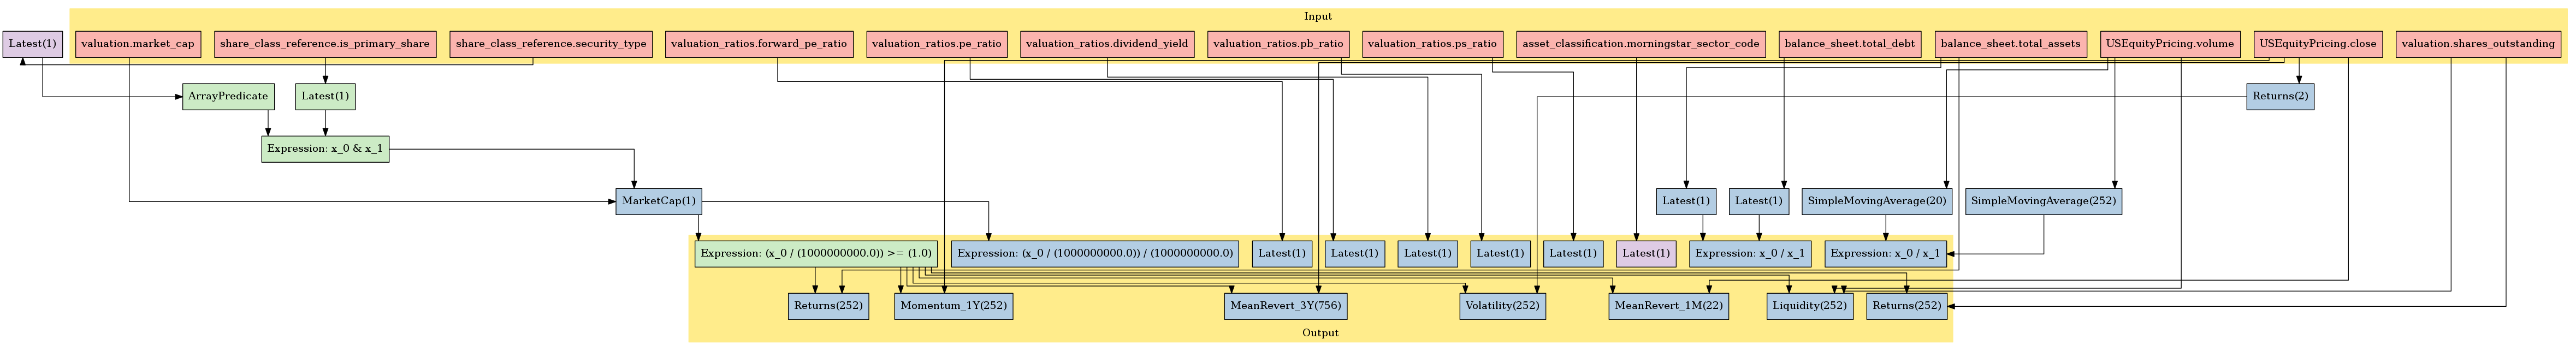

In [7]:
pipe.show_graph(format='png')

In [8]:
pipe_output = run_pipeline(pipe, start_date=start_date, end_date=end_date)
pipe_output.head()

asset_growth  chg_sharesout  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])      0.095831      -0.048123   
                          Equity(31 [ABAX])      0.126266       0.006844   
                          Equity(52 [ABM])       0.095995      -0.004442   
                          Equity(53 [ABMD])      0.298358       0.025370   
                          Equity(62 [ABT])       0.788405       0.181139   

                                             debt_to_assets  dividend_yield  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])        0.294507          0.0160   
                          Equity(31 [ABAX])        0.000910          0.0105   
                          Equity(52 [ABM])         0.116072          0.0162   
                          Equity(53 [ABMD])        0.029683             NaN   
                          Equity(62 [ABT])         0.338200          0.0216   

                                             forward_pe  liquidity  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])     14.1243   0.467440   
                          Equity(31 [ABAX])     39.8406   0.450415   
                          Equity(52 [ABM])      14.1243   0.423154   
                          Equity(53 [ABMD])     55.8659   0.780321   
                          Equity(62 [ABT])      19.8413   0.446218   

                                             mean_rev_1M  mean_rev_3Y  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])    -0.051040    -0.088072   
                          Equity(31 [ABAX])     0.061994    -0.051113   
                          Equity(52 [ABM])     -0.014999    -0.305236   
                          Equity(53 [ABMD])     0.070266    -0.771400   
                          Equity(62 [ABT])      0.106378     0.032610   

                                               mom_1Y  pe_ratio  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL]) -0.390348   17.0012   
                          Equity(31 [ABAX]) -0.066199   35.7569   
                          Equity(52 [ABM])  -0.150144   26.3949   
                          Equity(53 [ABMD]) -0.245157  124.3590   
                          Equity(62 [ABT])  -0.135427   54.5730   

                                             price_to_book_ratio  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])               5.6722   
                          Equity(31 [ABAX])               4.3815   
                          Equity(52 [ABM])                2.4649   
                          Equity(53 [ABMD])              14.1033   
                          Equity(62 [ABT])                2.6874   

                                             price_to_sales_ratio  sector  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                3.5492     311   
                          Equity(31 [ABAX])                5.1660     206   
                          Equity(52 [ABM])                 0.4470     310   
                          Equity(53 [ABMD])               14.5917     206   
                          Equity(62 [ABT])                 3.3665     206   

                                                     size  visibility  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])  7.605430e-07    0.954718   
                          Equity(31 [ABAX])  1.166450e-09    0.670397   
                          Equity(52 [ABM])   2.311090e-09    1.058786   
                          Equity(53 [ABMD])  6.375710e-09    0.747937   
                          Equity(62 [ABT])   8.428220e-08    0.897286   

                                             volatility  
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])    1.158884  
                          Equity(31 [ABAX])    2.055647  
                          Equity(52 [ABM])     1.314160  
                          Equity(53 [ABMD])    1.718629  
                          Equity(62 [ABT])     1.121708

In [9]:
pipe_output.shape

(2005, 16)

In [10]:
# remove rows with missing NaN
pipe_output = pipe_output[pipe_output.isnull().sum(axis=1) < 5]

In [11]:
pipe_output.sort_values('size', ascending=False)

asset_growth  chg_sharesout  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])           0.095831      -0.048123   
                          Equity(26578 [GOOG_L])      0.153652       0.007565   
                          Equity(5061 [MSFT])         0.237248      -0.017806   
                          Equity(16841 [AMZN])        0.324581       0.013028   
                          Equity(42950 [FB])          0.319520       0.013243   
                          Equity(11100 [BRK_B])       0.116211       0.001031   
                          Equity(4151 [JNJ])          0.063767      -0.020653   
                          Equity(47740 [BABA])             NaN       0.022664   
                          Equity(8347 [XOM])          0.004142       0.021864   
                          Equity(25006 [JPM])         0.050533      -0.028403   
                          Equity(8151 [WFC])          0.055366      -0.015704   
                          Equity(3149 [GE])          -0.239186      -0.055646   
                          Equity(6653 [T])            0.020476      -0.001300   
                          Equity(700 [BAC])           0.028462      -0.031153   
                          Equity(8229 [WMT])          0.005098      -0.027302   
                          Equity(5938 [PG])          -0.073854      -0.039161   
                          Equity(35920 [V])           0.163844       0.062932   
                          Equity(5923 [PFE])          0.035936      -0.015995   
                          Equity(23112 [CVX])        -0.017931       0.005232   
                          Equity(4283 [KO])          -0.000679      -0.012399   
                          Equity(1637 [CMCS_A])       0.069637       0.954087   
                          Equity(5692 [ORCL])         0.117686      -0.008477   
                          Equity(3496 [HD])           0.008256      -0.038955   
                          Equity(35902 [PM])          0.057942       0.001212   
                          Equity(21839 [VZ])          0.008766       0.000756   
                          Equity(5029 [MRK])         -0.022217      -0.011875   
                          Equity(7792 [UNH])          0.163778       0.013523   
                          Equity(1335 [C])            0.011476      -0.061899   
                          Equity(5885 [PEP])          0.065739      -0.011022   
                          Equity(2190 [DIS])          0.017094      -0.035477   
...                                                        ...            ...   
                          Equity(6907 [SJW])          0.059164       0.003569   
                          Equity(25150 [PLUS])        0.202763       0.972650   
                          Equity(32325 [CSII])        0.288589       0.001175   
                          Equity(24614 [IPCC])        0.004847      -0.000543   
                          Equity(7086 [SPXC])        -0.074944       0.018872   
                          Equity(46680 [TEDU])        0.002180       0.006050   
                          Equity(45942 [XNCR])        1.156635       0.146212   
                          Equity(44965 [GOGO])        0.288075       0.005302   
                          Equity(8586 [ALG])         -0.017348       0.009703   
                          Equity(35933 [IRDM])        0.130090       0.019615   
                          Equity(7958 [VHI])          0.007929       0.000047   
                          Equity(15397 [STRA])        0.130639       0.000529   
                          Equity(24445 [SAFT])        0.039428       0.004011   
                          Equity(27478 [CNSL])       -0.022502       0.001546   
                          Equity(11641 [FCH])        -0.095799      -0.004230   
                          Equity(47099 [ZPIN])             NaN      -0.106832   
                          Equity(28942 [HOLI])        0.009633       0.021879   
                          Equity(32331 [SGYP])        0.858088       0.251279   


#### Allocate Factor Weights and Settings

In [12]:
factors = { 'pe_ratio':{'ascending':False, 'weight':0.096},
            'forward_pe':{'ascending':False, 'weight':0.093},
            'price_to_sales_ratio':{'ascending':False, 'weight':0.089},
            'price_to_book_ratio':{'ascending':False, 'weight':0.092},
            'debt_to_assets':{'ascending':False, 'weight':0.085},
            'size':{'ascending':False, 'weight':0.074},
            'volatility':{'ascending':False, 'weight':0.083},
            'liquidity':{'ascending':False, 'weight':0.049},
            'dividend_yield':{'ascending':True, 'weight':0.046},
            'chg_sharesout':{'ascending':False, 'weight':0.088},
            'asset_growth':{'ascending':False, 'weight':0.082},
            'mean_rev_1M':{'ascending':False, 'weight':0.017},
            'mom_1Y':{'ascending':True, 'weight':0.013},
            'mean_rev_3Y':{'ascending':False, 'weight':0.014},
            'visibility':{'ascending':True, 'weight':0.078},
          }

factor_weights = 0
for factor_key, factor_vals in factors.items():
    factor_weights += factor_vals['weight']
print ("Totals Weight = %f" % (factor_weights * 100.))
factors

Totals Weight = 99.900000


{'asset_growth': {'ascending': False, 'weight': 0.082},
 'chg_sharesout': {'ascending': False, 'weight': 0.088},
 'debt_to_assets': {'ascending': False, 'weight': 0.085},
 'dividend_yield': {'ascending': True, 'weight': 0.046},
 'forward_pe': {'ascending': False, 'weight': 0.093},
 'liquidity': {'ascending': False, 'weight': 0.049},
 'mean_rev_1M': {'ascending': False, 'weight': 0.017},
 'mean_rev_3Y': {'ascending': False, 'weight': 0.014},
 'mom_1Y': {'ascending': True, 'weight': 0.013},
 'pe_ratio': {'ascending': False, 'weight': 0.096},
 'price_to_book_ratio': {'ascending': False, 'weight': 0.092},
 'price_to_sales_ratio': {'ascending': False, 'weight': 0.089},
 'size': {'ascending': False, 'weight': 0.074},
 'visibility': {'ascending': True, 'weight': 0.078},
 'volatility': {'ascending': False, 'weight': 0.083}}

#### Compute Factor Ranks and Scores

In [13]:
pipe_rank = pd.DataFrame(data=None, index=pipe_output.index)
pipe_sector = pipe_output.groupby('sector')

# universe rank
pipe_rank['sector'] = pipe_output['sector']
for factor_key, factor_vals in factors.items():
    pipe_rank[factor_key + '_univ'] = pipe_output[factor_key].rank(ascending=factor_vals['ascending'], pct=True)
    pipe_rank[factor_key + '_sector'] = pipe_sector[factor_key].rank(ascending=factor_vals['ascending'], pct=True)
    pipe_rank[factor_key + '_score'] = (0.5 * pipe_rank[factor_key + '_univ']) + (0.5 * pipe_rank[factor_key + '_sector'])

pipe_rank.sort_values('size_score', ascending=True).head(5)

sector  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])          311   
                          Equity(16841 [AMZN])       102   
                          Equity(11100 [BRK_B])      103   
                          Equity(26578 [GOOG_L])     311   
                          Equity(4151 [JNJ])         206   

                                                  price_to_book_ratio_univ  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                       0.242012   
                          Equity(16841 [AMZN])                    0.053955   
                          Equity(11100 [BRK_B])                   0.833421   
                          Equity(26578 [GOOG_L])                  0.300157   
                          Equity(4151 [JNJ])                      0.270822   

                                                  price_to_book_ratio_sector  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                         0.362369   
                          Equity(16841 [AMZN])                      0.105058   
                          Equity(11100 [BRK_B])                     0.599315   
                          Equity(26578 [GOOG_L])                    0.439024   
                          Equity(4151 [JNJ])                        0.518325   

                                                  price_to_book_ratio_score  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                        0.302190   
                          Equity(16841 [AMZN])                     0.079507   
                          Equity(11100 [BRK_B])                    0.716368   
                          Equity(26578 [GOOG_L])                   0.369591   
                          Equity(4151 [JNJ])                       0.394574   

                                                  chg_sharesout_univ  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                 0.926448   
                          Equity(16841 [AMZN])              0.331247   
                          Equity(11100 [BRK_B])             0.598331   
                          Equity(26578 [GOOG_L])            0.410537   
                          Equity(4151 [JNJ])                0.815336   

                                                  chg_sharesout_sector  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                   0.958188   
                          Equity(16841 [AMZN])                0.184615   
                          Equity(11100 [BRK_B])               0.587031   
                          Equity(26578 [GOOG_L])              0.557491   
                          Equity(4151 [JNJ])                  0.843750   

                                                  chg_sharesout_score  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                  0.942318   
                          Equity(16841 [AMZN])               0.257931   
                          Equity(11100 [BRK_B])              0.592681   
                          Equity(26578 [GOOG_L])             0.484014   
                          Equity(4151 [JNJ])                 0.829543   

                                                  debt_to_assets_univ  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                  0.487318   
                          Equity(16841 [AMZN])               0.783055   
                          Equity(11100 [BRK_B])              0.698327   
                          Equity(26578 [GOOG_L])             0.892067   
                          Equity(4151 [JNJ])                 0.614679   

                                                  debt_to_assets_sector  \
2017-06-22 00:00:00+00:00 Equity(24 [AAPL])                    0.333333   
                          Equity(16841 [AMZN])                 0.842520   
                          Equity(11100 [BRK_B])                0.264085   
                          Equity(26578 [GOOG_L])               0.798450   
                          Equity(4151 [JNJ])                   0.571429   

                                                  debt_to

#### Compute Final Score

In [14]:
def final_score(X, f):
    tmp = None
    for factor_key, factor_vals in factors.items():
        wgt = X[factor_key + '_score'] * factor_vals['weight']
        tmp = wgt if tmp is None else tmp + wgt
    return tmp

pipe_rank['score'] = pipe_rank.apply(final_score, args = (factors,), axis=1)
pipe_rank.sort_values('score', ascending=False)

sector  \
2017-06-22 00:00:00+00:00 Equity(5299 [NHC])         206   
                          Equity(412 [ANAT])         103   
                          Equity(661 [AVT])          311   
                          Equity(1287 [CBI])         310   
                          Equity(38630 [PMT])        104   
                          Equity(8612 [CHS])         102   
                          Equity(46965 [TIME])       102   
                          Equity(20456 [ARLP])       101   
                          Equity(8226 [WMK])         205   
                          Equity(36243 [AGNC])       104   
                          Equity(32084 [AHGP])       101   
                          Equity(5660 [OMI])         206   
                          Equity(23438 [GME])        102   
                          Equity(38477 [CYS])        104   
                          Equity(18590 [MFA])        104   
                          Equity(13320 [AVX])        311   
                          Equity(21090 [TGT])        205   
                          Equity(46003 [FGL])        103   
                          Equity(25305 [AXS])        103   
                          Equity(2329 [UFS])         101   
                          Equity(38531 [IVR])        104   
                          Equity(7728 [UFCS])        103   
                          Equity(8354 [XRX])         311   
                          Equity(128 [ADM])          205   
                          Equity(27409 [DSW])        102   
                          Equity(739 [BBBY])         102   
                          Equity(9774 [SIG])         102   
                          Equity(13720 [RE])         103   
                          Equity(23328 [PRU])        103   
                          Equity(11086 [AEO])        102   
...                                                  ...   
                          Equity(49458 [MSG])         -1   
                          Equity(49460 [NVCR])       206   
                          Equity(49495 [TWNK])       205   
                          Equity(49496 [FDC])        310   
                          Equity(49506 [HPE])        311   
                          Equity(49515 [RACE])       102   
                          Equity(49543 [FCPT])        -1   
                          Equity(49606 [MIME])       311   
                          Equity(49608 [MTCH])        -1   
                          Equity(49610 [SQ])          -1   
                          Equity(49627 [RMR])        104   
                          Equity(49630 [CSRA])       311   
                          Equity(49655 [TEAM])        -1   
                          Equity(49674 [YRD])         -1   
                          Equity(49700 [FCE_A])      104   
                          Equity(49727 [GCP])         -1   
                          Equity(49737 [BGNE])        -1   
                          Equity(49760 [WBT])        310   
                          Equity(49878 [BATR_A])      -1   
                          Equity(49881 [LSXM_A])     102   
                          Equity(49885 [FWON_A])      -1   
                          Equity(49891 [MGP])        104   
                          Equity(49902 [ENIC])        -1   
                          Equity(49908 [RRR])         -1   
                          Equity(49925 [NGVT])        -1   
                          Equity(50002 [COTV])        -1   
                          Equity(50003 [USFD])        -1   
                          Equity(50004 [GMS])         -1   
                          Equity(50040 [ATKR])        -1   
                          Equity(50049 [FTV])         -1   

                                                  price_to_book_ratio_univ  \
2017-06-22 00:00:00+00:00 Equity(5299 [NHC])                      0.783656   
                          Equity(412 [ANAT])                      0.988476   
                          Equity(661 [AVT])                       0.954426   
                 